In [1]:
import os
# 1. Imposta il percorso di Java 11 (usa l'output del comando sopra)
java_home_path = "/Library/Java/JavaVirtualMachines/openjdk-11.jdk/Contents/Home"
os.environ["JAVA_HOME"] = java_home_path

# 2. Aggiungi Java al PATH
os.environ["PATH"] = f"{java_home_path}/bin:{os.environ['PATH']}"

# 3. Verifica (opzionale)
!java -version



java version "21.0.2" 2024-01-16 LTS
Java(TM) SE Runtime Environment (build 21.0.2+13-LTS-58)
Java HotSpot(TM) 64-Bit Server VM (build 21.0.2+13-LTS-58, mixed mode, sharing)


In [ ]:
#### JAVA MAC
import os
from pyspark.sql import SparkSession

# 1. Configurazione ambiente Java e Spark
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/openjdk-11.jdk/Contents/Home"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages org.mongodb.spark:mongo-spark-connector_2.12:10.5.0 pyspark-shell"

# 2. Inizializzazione Spark con configurazione esplicita
spark = SparkSession.builder \
    .appName("ClinicalDataAnalysis") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.5.0") \
    .config("spark.mongodb.read.connection.uri", "mongodb://localhost:27017/cartella_clinica_db.interventi") \
    .getOrCreate()

# 3. Lettura dati con sintassi corretta
df = spark.read \
  .format("mongodb") \
  .option("uri", "mongodb://localhost:27017") \
  .option("database", "cartella_clinica_db") \
  .option("collection", "interventi") \
  .load()

# Verifica
df.show(10)

In [ ]:
### JAVA WINDOWS

import os
# 1. Imposta il percorso di Java 11 (usa l'output del comando sopra)
java_home_path = r"C:\Program Files\Java\jdk-11"
os.environ["HADOOP_HOME"] = r"C:\Program Files\hadoop"
os.environ["JAVA_HOME"] = java_home_path

# 2. Aggiungi Java al PATH
os.environ["PATH"] = f"{java_home_path}\\bin;{os.environ['PATH']}"

# 3. Verifica (opzionale)
!java -version

java version "11.0.27" 2025-04-15 LTS
Java(TM) SE Runtime Environment 18.9 (build 11.0.27+8-LTS-232)
Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.27+8-LTS-232, mixed mode)


In [ ]:
#### SPARK WINDOWS
import os
from pyspark.sql import SparkSession

# 1. Configurazione ambiente Spark
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages org.mongodb.spark:mongo-spark-connector_2.12:10.1.1 pyspark-shell"

# 2. Inizializzazione Spark con configurazione esplicita
spark = SparkSession.builder \
    .appName("ClinicalDataAnalysis") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.5.0") \
    .config("spark.mongodb.read.connection.uri", "mongodb://localhost:27017/cartella_clinica_db.interventi") \
    .getOrCreate()

# 3. Lettura dati con sintassi corretta
df = spark.read \
  .format("mongodb") \
  .option("uri", "mongodb://localhost:27017") \
  .option("database", "cartella_clinica_db") \
  .option("collection", "interventi") \
  .load()

# Verifica
df.show(10)



+--------------------+--------------------+-----------+-----+-------+---------------+----------------+--------------+-------------+-----------------+---------------------+--------------------+----------+-------------+-----------------+------------------+-------------+---------------+---------------------+------------------+---------------+--------------------------+----------------+--------------------+-------------------+-------------+---------------+---------------------+--------------+-------------------+-------------------+-------------------+--------------------+-------------+-----------------+-------------+--------------------+------------+----------------------+----------------------+----------------+---------------------+--------------------+--------------------+-------------------+----------------------+--------------------------+-----------------------+--------------------+---------+-----------------+-------------------+----------------------+--------------------+------------

# Tempo di servizio ambulanza

In [4]:
from pyspark.sql.functions import unix_timestamp, col, round

# Converte gli orari in timestamp e calcola la differenza in minuti
df_tempo = df.withColumn("partenza_ts", unix_timestamp(col("ora_partenza_ambulanza"), "HH:mm")) \
             .withColumn("arrivo_ts", unix_timestamp(col("ora_arrivo_ps"), "HH:mm")) \
             .withColumn("durata_minuti", round((col("arrivo_ts") - col("partenza_ts")) / 60))

# Mostra i tempi di occupazione
df_tempo.select("ora_partenza_ambulanza", "ora_arrivo_ps", "durata_minuti") \
        .orderBy(col("durata_minuti").desc()) \
        .show(10)

# Salva in CSV
df_tempo.select("ora_partenza_ambulanza", "ora_arrivo_ps", "durata_minuti") \
        .toPandas() \
        .to_csv("output/tempi_occupazione_ambulanza.csv", index=False)



+----------------------+-------------+-------------+
|ora_partenza_ambulanza|ora_arrivo_ps|durata_minuti|
+----------------------+-------------+-------------+
|                 14:25|        15:05|         40.0|
|                 08:45|        09:24|         39.0|
|                 09:23|        10:00|         37.0|
|                 09:48|        10:25|         37.0|
|                 14:33|        15:10|         37.0|
|                 10:18|        10:49|         31.0|
|                  null|         null|         null|
|                  null|         null|         null|
|                  null|         null|         null|
|                  null|         null|         null|
+----------------------+-------------+-------------+
only showing top 10 rows



# Tempo di servizio ambulanza per città (per vedere se ci sono città più lente o più veloci di altre)

In [5]:
from pyspark.sql.functions import unix_timestamp, col, round, when, count, sum

# Calcola la durata in minuti
df = df.withColumn("partenza_ts", unix_timestamp(col("ora_partenza_ambulanza"), "HH:mm")) \
       .withColumn("arrivo_ts", unix_timestamp(col("ora_arrivo_ps"), "HH:mm")) \
       .withColumn("durata_minuti", round((col("arrivo_ts") - col("partenza_ts")) / 60))

# Definisci soglie per rapido e lento
soglia_rapido = 10
soglia_lento = 30

# Aggiungi colonne per classificare
df = df.withColumn("is_rapido", when(col("durata_minuti") <= soglia_rapido, 1).otherwise(0)) \
       .withColumn("is_lento", when(col("durata_minuti") >= soglia_lento, 1).otherwise(0))

# Raggruppa per città e calcola totali e percentuali
df_riepilogo = df.groupBy("citta").agg(
    count("*").alias("totale_interventi"),
    sum("is_rapido").alias("interventi_rapidi"),
    sum("is_lento").alias("interventi_lenti")
)

df_percentuali = df_riepilogo.withColumn(
    "percentuale_rapidi",
    round((col("interventi_rapidi") / col("totale_interventi")) * 100, 2)
).withColumn(
    "percentuale_lenti",
    round((col("interventi_lenti") / col("totale_interventi")) * 100, 2)
)

# Mostra il risultato ordinato per città
df_percentuali.orderBy("citta").show(truncate=False)

# Salva in CSV nella cartella output
df_percentuali.toPandas().to_csv("output/distribuzione_ambulanze_estreme.csv", index=False)


+--------+-----------------+-----------------+----------------+------------------+-----------------+
|citta   |totale_interventi|interventi_rapidi|interventi_lenti|percentuale_rapidi|percentuale_lenti|
+--------+-----------------+-----------------+----------------+------------------+-----------------+
|Bologna |1                |0                |1               |0.0               |100.0            |
|Fidenza |2                |0                |2               |0.0               |100.0            |
|Firenze |1                |0                |1               |0.0               |100.0            |
|Milano  |1                |0                |1               |0.0               |100.0            |
|Modena  |3                |0                |0               |0.0               |0.0              |
|Parma   |9                |0                |0               |0.0               |0.0              |
|Piacenza|1                |0                |1               |0.0               |100.0    

# Analitica Area Geografica

In [6]:
from pyspark.sql.functions import col
import os

# Assicurati che la cartella di output esista
os.makedirs("output", exist_ok=True)

# Calcola top 10 città con più interventi
top_cities = df.groupBy("citta") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(10)

spark.conf.set("spark.hadoop.io.native.lib.available", "false")

# Trasformo in pandas
top_cities_pd = top_cities.toPandas()

# Salvo in CSV
top_cities_pd.to_csv("output/top_citta_interventi.csv", index=False)



In [6]:
total = df.count()

df.groupBy("codice_uscita") \
  .count() \
  .withColumn("percentuale", (col("count") / total) * 100) \
  .orderBy("percentuale", ascending=False) \
  .show()


+-------------+-----+-----------+
|codice_uscita|count|percentuale|
+-------------+-----+-----------+
|           D2|    4|       50.0|
|           D4|    2|       25.0|
|           D3|    2|       25.0|
+-------------+-----+-----------+



In [46]:
# Esegui la query Spark per aggregare
df_eff = df.groupBy("codice_uscita", "codice_rientro") \
           .count() \
           .orderBy("count", ascending=False)

# Converti il DataFrame Spark in Pandas
df_eff_pd = df_eff.toPandas()

# Salva in CSV
df_eff_pd.to_csv("output/codici_efficienza.csv", index=False)


C:\Users\Sara\AppData\Local\Temp\ipykernel_18576\2987412968.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=eta_df, x="reparto_destinazione", y="eta_media", palette="viridis")


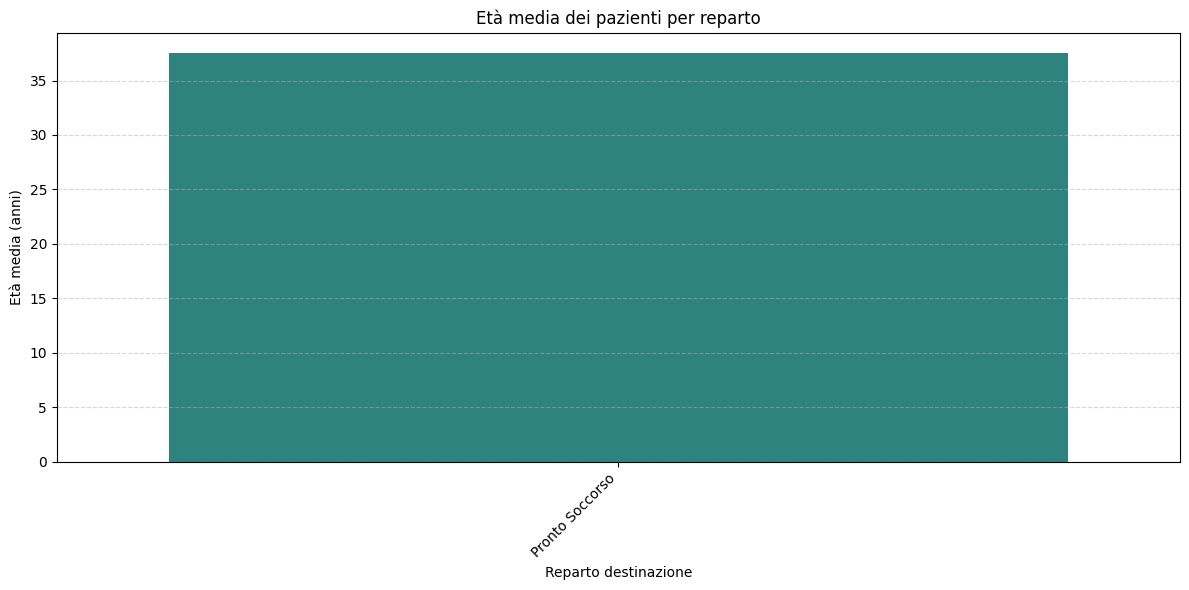

In [14]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

# Estrae il numero all'inizio della stringa e lo converte in intero
df_clean = df.withColumn("eta_int", regexp_extract(col("eta"), r"(\d+)", 1).cast("int"))


# Calcolo dell'età media per reparto
eta_df = df_clean.select("reparto_destinazione", "eta_int") \
                 .groupBy("reparto_destinazione") \
                 .avg("eta_int") \
                 .withColumnRenamed("avg(eta_int)", "eta_media") \
                 .orderBy("eta_media", ascending=False) \
                 .toPandas()

# Rimozione reparti null o vuoti
eta_df = eta_df[eta_df["reparto_destinazione"].notnull()]
eta_df = eta_df[eta_df["reparto_destinazione"].str.strip() != ""]

# Plot ordinato
plt.figure(figsize=(12, 6))
sns.barplot(data=eta_df, x="reparto_destinazione", y="eta_media", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Età media (anni)")
plt.xlabel("Reparto destinazione")
plt.title("Età media dei pazienti per reparto")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
